In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import warnings

In [18]:
warnings.filterwarnings("ignore")
color = sns.color_palette()
%matplotlib inline

In [3]:
#increase the field_size_limit

import sys
import csv
maxInt = sys.maxsize
decrement = True

while decrement:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt/10)
        decrement = True

In [4]:
trainV = pd.read_csv("training_variants.csv")

In [5]:
trainV.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [6]:
trainV.shape

(3321, 4)

In [7]:
def read_this_funky_csv(source):
  # be sure to pass a source object that supports
  # iteration (e.g. a file object, or a list of csv text lines)
  return csv.reader((line.replace('||', '|') for line in source), delimiter='|')

In [8]:
#trainT = pd.read_csv('training_text',sep="||")

fileHandle = open('training_text', 'r')

In [9]:
pipereader = read_this_funky_csv(fileHandle)

In [10]:
fileHandle.seek(0)

In [11]:
columns = next(pipereader)

In [12]:
newcolumns = columns[0].split(',')
newcolumns

['ID', 'Text']

In [13]:
df = pd.DataFrame(columns=newcolumns)

In [14]:
i = 0
ls = []
try:
    while True:
        ls = next(pipereader)
        df.loc[i] = [int(i),ls[1]]
        i += 1
except StopIteration:
    pass
finally:
    del pipereader 

In [15]:
df['ID'] = df['ID'].astype(int)

In [16]:
df.head()   

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [20]:
train_text_df = df.copy()
del df

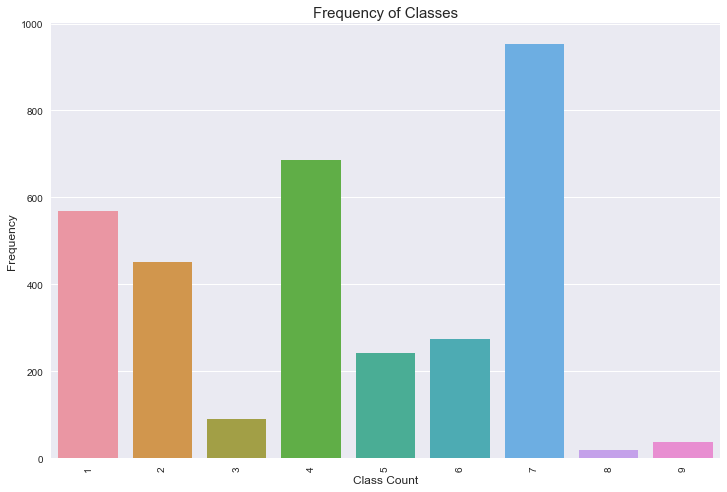

In [21]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=trainV)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()